<a href="https://colab.research.google.com/github/choieunsol/test/blob/master/20171712.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load data

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split

path = '/content/CIFAR10'
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_set = torchvision.datasets.CIFAR10(path, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_set, [35000, 15000])


train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size=1024,
                                          shuffle=False,
                                          num_workers=1)


path = '/content/CIFAR10_test'
test_set = torchvision.datasets.CIFAR10(path, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=1024,
                                          num_workers=1)



Extracting /content/CIFAR10/cifar-10-python.tar.gz to /content/CIFAR10


Extracting /content/CIFAR10_test/cifar-10-python.tar.gz to /content/CIFAR10_test


In [2]:
# Check GPU

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

is_cuda = False
if torch.cuda.is_available():
  is_cuda = True

In [33]:
# Construct model

import torch.nn as nn
import torch.optim as optim


def conv(in_channels, out_channels):
  return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True)


class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        conv(3, 64), 
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        conv(64, 64), 
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.conv2 =  nn.Sequential(
        conv(64, 128), 
        nn.BatchNorm2d(128), 
        nn.ReLU(),
        conv(128, 128), 
        nn.BatchNorm2d(128), 
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.conv3 = nn.Sequential(
        conv(128, 256), 
        nn.BatchNorm2d(256), 
        nn.ReLU(),
        conv(256, 256), 
        nn.BatchNorm2d(256), 
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.conv4 = nn.Sequential(
        conv(256, 512), 
        nn.BatchNorm2d(512), 
        nn.ReLU(),
        conv(512, 512), 
        nn.BatchNorm2d(512), 
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.conv5 = nn.Sequential(
        conv(512, 512), 
        nn.BatchNorm2d(512), 
        nn.ReLU(),
        conv(512, 512), 
        nn.BatchNorm2d(512), 
        nn.ReLU(),
        nn.MaxPool2d(2,2)
        #nn.AdaptiveAvgPool2d(4)
    )
    
    self.fc = nn.Sequential(nn.Linear(512, 512),
                             nn.ReLU(),
                             nn.Dropout(),
                             nn.Linear(512, 512),
                             nn.ReLU(),
                             nn.Dropout(),
                             nn.Linear(512, 10))
    

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.view(-1, 512)
    x = self.fc(x)
    return x

In [34]:
# Configure loss function and optimizer
model = Net().cuda()
print(model)

criterion = nn.NLLLoss()
softmax = nn.LogSoftmax(dim=1)
optimizer = optim.Adam(model.parameters())

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, 

In [40]:
# Training

from torch.autograd import Variable
import copy

epochs = 30
losses = list()
accuracies = list()
torch.save(model.state_dict(), 'pretrained_weights.pth')
best_model = copy.deepcopy(model.state_dict())
best_accuracy = 0

for epoch in range(epochs):
  epoch_loss = 0
  epoch_accuracy = 0
  batch = 0

  model.train()
  for idx, (x, y) in enumerate(train_loader):
    x = x.cuda()
    y = y.cuda()

    optimizer.zero_grad()
    output = model(x)
    
    loss = criterion(softmax(output),y)
    loss.backward()

    optimizer.step()
    
    _, y_pred = torch.max(output, 1)
    accuracy = sum(y == y_pred)

    epoch_accuracy += accuracy.item()
    epoch_loss += loss.item()

    batch += len(x)
    print('Epoch: {} [{}/{} ({:.0f}%)],\tAccuracy: {:.1f}%,  \t Loss: {:.6f}'.format(
        epoch+1, batch, len(train_loader.dataset),100. * (idx+1) / len(train_loader), 100.*(accuracy.item()/len(x)), loss.item()))
  
  

  val_accuracy = 0
  val_loss = 0

  model.eval()
  for idx, (x, y) in enumerate(val_loader):
    x = x.cuda()
    y = y.cuda()

    optimizer.zero_grad()
    output = model(x)
    
    loss = criterion(softmax(output),y)
    loss.backward()

    optimizer.step()
    
    _, y_pred = torch.max(output, 1)
    accuracy = sum(y == y_pred)

    val_accuracy += accuracy.item()
    val_loss += loss.item()
  print("=====================================================")
  print('Validation Accuracy: {:.1f}%,  \t Loss: {:.6f}'.format(
      100.*(val_accuracy/len(val_loader.dataset)), val_loss/len(val_loader)))
  print("=====================================================")

  if val_accuracy >= best_accuracy:
    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = val_accuracy
    print('Best model is updated.')
  
  losses.append(val_loss/len(val_loader))
  accuracies.append((val_accuracy/len(val_loader.dataset)))


Epoch: 1 [256/35000 (1%)],	Accuracy: 96.9%,  	 Loss: 0.075000
Epoch: 1 [512/35000 (1%)],	Accuracy: 96.5%,  	 Loss: 0.145868
Epoch: 1 [768/35000 (2%)],	Accuracy: 96.9%,  	 Loss: 0.119656
Epoch: 1 [1024/35000 (3%)],	Accuracy: 97.7%,  	 Loss: 0.085983
Epoch: 1 [1280/35000 (4%)],	Accuracy: 94.5%,  	 Loss: 0.194802
Epoch: 1 [1536/35000 (4%)],	Accuracy: 96.9%,  	 Loss: 0.111438
Epoch: 1 [1792/35000 (5%)],	Accuracy: 97.7%,  	 Loss: 0.090139
Epoch: 1 [2048/35000 (6%)],	Accuracy: 98.0%,  	 Loss: 0.088175
Epoch: 1 [2304/35000 (7%)],	Accuracy: 98.0%,  	 Loss: 0.076799
Epoch: 1 [2560/35000 (7%)],	Accuracy: 97.7%,  	 Loss: 0.059395
Epoch: 1 [2816/35000 (8%)],	Accuracy: 98.0%,  	 Loss: 0.077788
Epoch: 1 [3072/35000 (9%)],	Accuracy: 98.4%,  	 Loss: 0.062324
Epoch: 1 [3328/35000 (9%)],	Accuracy: 97.7%,  	 Loss: 0.094981
Epoch: 1 [3584/35000 (10%)],	Accuracy: 95.3%,  	 Loss: 0.169346
Epoch: 1 [3840/35000 (11%)],	Accuracy: 98.4%,  	 Loss: 0.126959
Epoch: 1 [4096/35000 (12%)],	Accuracy: 99.2%,  	 Loss: 0

In [41]:
model.load_state_dict(best_model)  
# torch.save(model.state_dict(), 'pretrained_weights.pth')

<All keys matched successfully>

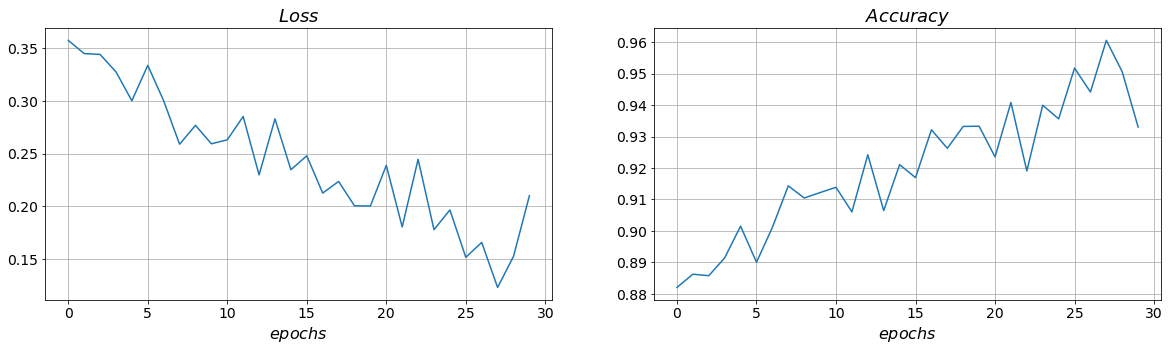

In [42]:
# Plot result


import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title("$Loss$",fontsize = 18)
plt.plot(losses)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


plt.subplot(1,2,2)
plt.title("$Accuracy$", fontsize = 18)
plt.plot(accuracies)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

In [43]:
# Test

y_pred_list = []

batch = 0
test_accuracy = 0

model.eval()
for idx, (x, y) in enumerate(test_loader):
  x = x.cuda()
  y = y.cuda()

  output = model(x)
  loss = criterion(softmax(output),y)
  
  _, y_pred = torch.max(output, 1)
  y_pred_list += y_pred.tolist()
  
  accuracy = sum(y == y_pred)
  test_accuracy += accuracy.item()
  batch += len(x)
  
  print('Test:  [{}/{} ({:.0f}%)],\tAccuracy: {:.1f}%,  \t Loss: {:.6f}'.format(
      batch, len(test_loader.dataset), 100.*(idx+1)/len(test_loader), 100.*(test_accuracy/batch), loss.item()))


Test:  [1024/10000 (10%)],	Accuracy: 82.4%,  	 Loss: 0.734854
Test:  [2048/10000 (20%)],	Accuracy: 82.1%,  	 Loss: 0.871761
Test:  [3072/10000 (30%)],	Accuracy: 82.1%,  	 Loss: 0.811147
Test:  [4096/10000 (40%)],	Accuracy: 82.3%,  	 Loss: 0.780952
Test:  [5120/10000 (50%)],	Accuracy: 81.9%,  	 Loss: 0.864891
Test:  [6144/10000 (60%)],	Accuracy: 82.2%,  	 Loss: 0.788868
Test:  [7168/10000 (70%)],	Accuracy: 82.2%,  	 Loss: 0.844802
Test:  [8192/10000 (80%)],	Accuracy: 82.2%,  	 Loss: 0.848986
Test:  [9216/10000 (90%)],	Accuracy: 82.2%,  	 Loss: 0.807910
Test:  [10000/10000 (100%)],	Accuracy: 82.0%,  	 Loss: 0.928314


In [47]:
import pandas as pd

submission = pd.DataFrame(y_pred_list)
submission.columns = ['prediction']
submission.index.name = 'Id'
submission.to_csv('submission.csv')